## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [0]:
# !wget https://www.dropbox.com/s/xjs6g83d1qhj3gj/models.zip
# !unzip models.zip
# !rm models.zip

In [0]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.
from IPython.display import clear_output
! pip  install subword-nmt
! pip install nltk
! pip install torchtext
! pip install transformers
!curl -L https://www.dropbox.com/s/jr88djs2ia2t6on/my_network.py?dl=0 -o my_network.py
!curl -L https://www.dropbox.com/s/y750nfv0bsfjog9/utils.py?dl=0 -o utils.py
!wget https://www.dropbox.com/s/busgrderer0l31n/my_network_bert
!wget https://www.dropbox.com/s/i7huxosdxh9so1s/attention.py
clear_output()

In [19]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2020-05-21 16:28:14--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  36.0MB/s    in 0.3s    

2020-05-21 16:28:14 (36.0 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import pandas as pd
import spacy

from nltk.translate.bleu_score import corpus_bleu
import tqdm
import random
import math
import time
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [0]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6724


Here are tokens from original (RU) corpus:

In [0]:
SRC.vocab.itos[::1000]

['<unk>',
 '350',
 'будапешта',
 'лыжной',
 'den',
 'флорианополис',
 'f',
 'термальная',
 'деталями',
 'тавира']

And from target (EN) corpus:

In [0]:
TRG.vocab.itos[::1000]

['<unk>', 'berlin', 'blankets', 'colorful', 'mina', 'smaller', 'lugo']

And here is example from train dataset:

In [0]:
print(vars(train_data.examples[9]))

{'trg': ['free', 'parking', 'is', 'available', 'at', 'the', 'apartments', '.'], 'src': ['гостям', 'апартаментов', 'предоставляется', 'бесплатная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


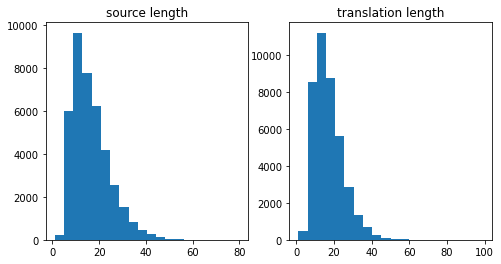

In [0]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


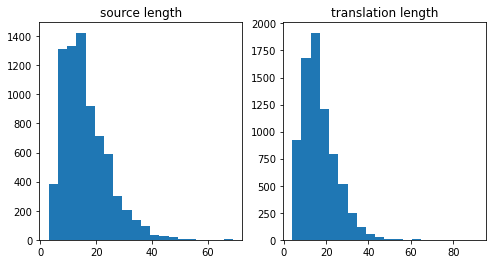

In [0]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
torch.Size([46, 128]) torch.Size([46, 128])


In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

**Baseline**

In [0]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9299, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6695, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6695, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,885,415 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        src = batch.src
        trg = batch.trg
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    model.eval()    
    epoch_loss = 0
    history = []

    with torch.no_grad():
      for i, batch in enumerate(iterator): #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
            
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)          
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

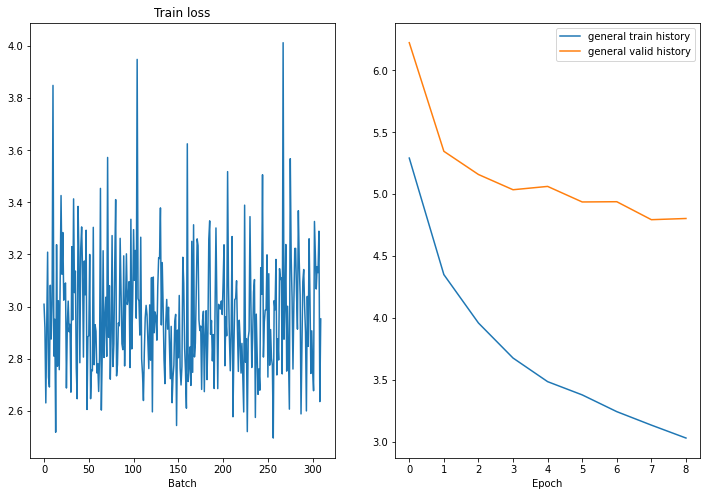

Epoch: 10 | Time: 1m 24s
	Train Loss: 2.966 | Train PPL:  19.418
	 Val. Loss: 4.807 |  Val. PPL: 122.358


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
for idx in [0,15]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: the kitchen is fitted with a dishwasher .
Generated: the kitchen is equipped with a dishwasher and a .



In [0]:
#     """ Estimates corpora-level BLEU score of model's translations
#  given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines 
# into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) 
                                for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) 
                                for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 16.23it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.580405981207116

# RNN + Attention

In [0]:
import attention

Encoder = attention.Encoder
Attention = attention.Attention
Decoder_Attention = attention.Decoder_Attention
Seq2Seq = attention.Seq2Seq

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = Decoder_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

model_attn = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
model_attn.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): LSTM(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_Attention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(6724, 256)
    (rnn): GRU(768, 512)
    (out): Linear(in_features=1280, out_features=6724, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model with attention has {count_parameters(model_attn):,} trainable parameters')

The model with attention has 16,776,516 trainable parameters


In [0]:
PAD = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model_attn.parameters(), lr=6e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

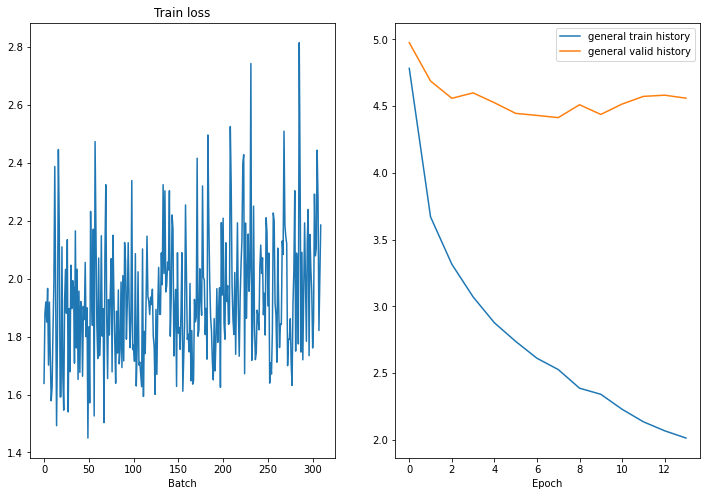

Epoch: 15 | Time: 2m 19s
	Train Loss: 1.929 | Train PPL:   6.886
	 Val. Loss: 4.610 |  Val. PPL: 100.439


In [0]:
for epoch in range(N_EPOCHS):
    start_time = time.time()    
    train_loss = train(model_attn, train_iterator, optimizer, criterion, 
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model_attn, valid_iterator, criterion)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attn.state_dict(), 'attn-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
def print_learning(title, train_history, valid_history):
  print(f'Best {title} model loss is {np.min(valid_history):.4}')
  plt.figure(figsize=[12, 4])
  plt.subplot(1, 2, 1)
  plt.title(f"{title} train loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.grid()
  plt.plot(train_history)

  plt.subplot(1, 2, 2)
  plt.title(f"{title} validation loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.grid()
  plt.plot(valid_history)
  plt.plot(np.argmin(valid_history), np.min(valid_history), 'ro');

Best attention model loss is 4.414


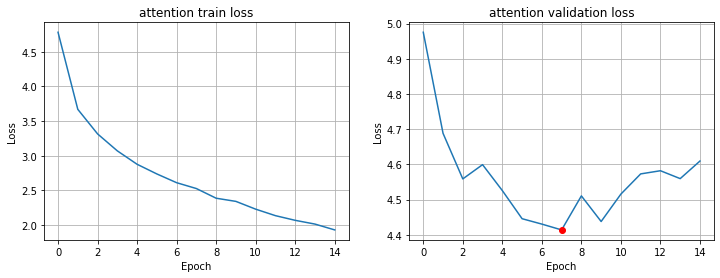

In [0]:
print_learning('attention', train_history, valid_history)

In [0]:
with open("attn-model.pt", "rb") as fp:
    best_attn_mod = model_attn
    state_dict = torch.load(fp, map_location=device)
    best_attn_mod.load_state_dict(state_dict)

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
original_text = []
translated_text = []
generated_text = []
best_attn_mod.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = best_attn_mod(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) 
                                for x in trg.cpu().numpy().T])
        translated_text.extend([get_text(x, SRC.vocab) 
                                for x in src.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) 
                                for x in output[1:].detach().cpu().numpy().T])

59it [00:05, 11.68it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

23.832946496516342

In [0]:
for i in range(5):
  print(f"""
  Source text:\t\t {' '.join(translated_text[i])}
  Target translation:\t {' '.join(original_text[i])}
  Model translation:\t {' '.join(generated_text[i])}""")


  Source text:		 в хостеле имеется ресторан .
  Target translation:	 guests can enjoy the on - site restaurant .
  Model translation:	 restaurant .

  Source text:		 ежедневно предоставляются услуги горничной .
  Target translation:	 other facilities offered at the property include daily maid service .
  Model translation:	 daily .

  Source text:		 до флоренции 29 км .
  Target translation:	 florence is 29 km away .
  Model translation:	 split airport is located km away .

  Source text:		 неподалеку оборудована бесплатная парковка .
  Target translation:	 free parking is available nearby .
  Model translation:	 parking is available nearby .

  Source text:		 гостям предоставляется бесплатная парковка .
  Target translation:	 the property offers free parking .
  Model translation:	 parking is provided .


# RNN + Attention + optimization

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = Decoder_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

model_attn2 = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
model_attn2.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9299, 256)
    (rnn): LSTM(256, 512, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder_Attention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(6695, 256)
    (rnn): GRU(768, 512)
    (out): Linear(in_features=1280, out_features=6695, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [0]:
print(f'The model with attention has {count_parameters(model_attn2):,} trainable parameters')

The model with attention has 16,741,671 trainable parameters


In [0]:
PAD = TRG.vocab.stoi['<pad>']
optimizer = optim.AdamW(model_attn2.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, 
                              patience=0, min_lr=1e-6, verbose=True)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

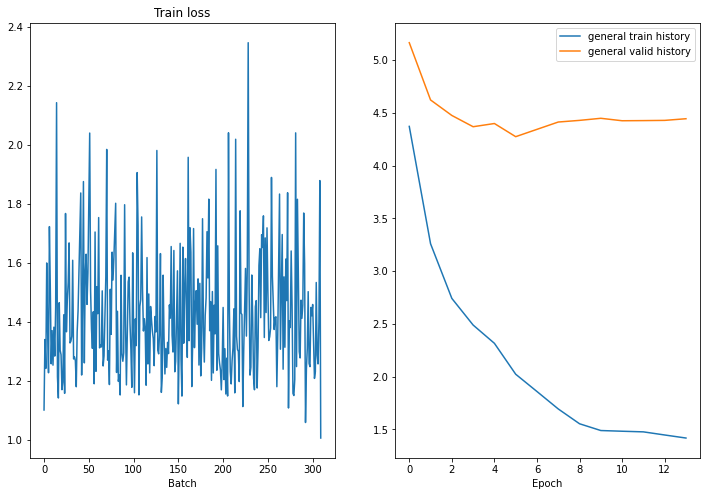

Epoch    15: reducing learning rate of group 0 to 4.8828e-06.
Epoch: 15 | Time: 2m 23s
	Train Loss: 1.427 | Train PPL:   4.167
	 Val. Loss: 4.448 |  Val. PPL:  85.486


In [0]:
for epoch in range(N_EPOCHS):
    start_time = time.time()    
    train_loss = train(model_attn2, train_iterator, optimizer, criterion, 
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model_attn2, valid_iterator, criterion)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attn2.state_dict(), 'attn-model2.pt')

    lr_scheduler.step(valid_loss)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Best attention with optimization model loss is 4.274


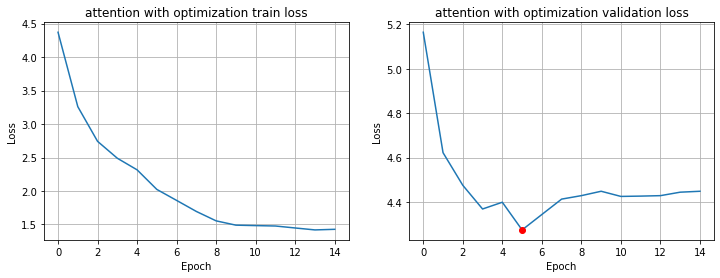

In [0]:
print_learning('attention with optimization', train_history, valid_history)

In [0]:
with open("attn-model2.pt", "rb") as fp:
    best_attn_mod2 = model_attn2
    state_dict = torch.load(fp, map_location=device)
    best_attn_mod2.load_state_dict(state_dict)

In [0]:
original_text = []
translated_text = []
generated_text = []
best_attn_mod2.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = best_attn_mod2(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) 
                                for x in trg.cpu().numpy().T])
        translated_text.extend([get_text(x, SRC.vocab) 
                                for x in src.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) 
                                for x in output[1:].detach().cpu().numpy().T])

59it [00:05, 11.53it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.680328123519413

In [0]:
for i in range(5):
  print(f"""
  Source text:\t\t {' '.join(translated_text[i])}
  Target translation:\t {' '.join(original_text[i])}
  Model translation:\t {' '.join(generated_text[i])}""")


  Source text:		 стойка регистрации работает круглосуточно .
  Target translation:	 you will find a 24 - hour front desk at the property .
  Model translation:	 you will find a 24 - hour front desk at the property .

  Source text:		 в ресторане сервируется завтрак .
  Target translation:	 breakfast is served in the restaurant .
  Model translation:	 breakfast is served in the restaurant .

  Source text:		 стойка регистрации открыта круглосуточно .
  Target translation:	 you will find a 24 - hour front desk at the property .
  Model translation:	 there is a 24 - hour front desk at the property .

  Source text:		 гости могут заказать завтрак .
  Target translation:	 breakfast can also be ordered there .
  Model translation:	 breakfast breakfast is available .

  Source text:		 при отеле работает парикмахерская .
  Target translation:	 there is a hairdresser ' s at the property .
  Model translation:	 you will find a hairdresser ' s at the property .


##BERT

In [12]:
import transformers as ppb
model = ppb.AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased")
tokenizer = ppb.AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model.cls.predictions.decoder = nn.Linear(model.cls.predictions.decoder.in_features, 
                                          768, bias=True)

In [0]:
# Оставляем только три первых слоя, тк сеть предобучена под задачу классивикации
model.bert.encoder.layer = model.bert.encoder.layer[:3]

In [0]:
# model = torch.nn.Sequential((list(model.children())[0]))

In [15]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [0]:
bert_model = model.to(device)

In [0]:
def tokenize_for_bert(x, **kwargs):
    return tokenizer.encode(x, max_length=512, add_special_tokens=False, **kwargs)

In [0]:
pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

SRC = Field(
    use_vocab=False,
    tokenize=tokenize_for_bert,
    pad_token=pad_index
)

TRG = Field(
    tokenize=tokenize, 
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [22]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [23]:
example = vars(train_data.examples[0])
print(example)

{'trg': ['apartaments', 'fontalba', 'features', 'rustic', '-', 'style', 'studios', 'with', 'a', 'private', 'furnished', 'terrace', '.'], 'src': [845, 27294, 12953, 15034, 67623, 5200, 242, 19511, 4676, 11049, 20734, 130, 7424, 9411, 869, 39814, 1455, 845, 47207, 2186, 15849, 851, 22356, 852, 27927, 17189, 73149, 852, 44007, 15484, 132]}


In [0]:
TRG.build_vocab(train_data, min_freq = 2)

In [67]:
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in target (en) vocabulary: 10231


In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key)

In [0]:
bert_model.eval()
bert_model.to(device)
_ = 1

In [0]:
a = next(iter(train_iterator))

In [0]:
outputs = bert_model(a.src)

In [30]:
outputs[0].shape

torch.Size([49, 128, 768])

In [0]:
import my_network_bert
Encoder = my_network_bert.Encoder
Decoder = my_network_bert.Decoder
Seq2Seq = my_network_bert.Seq2Seq

In [0]:
INPUT_DIM = len(TRG.vocab) # len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 768
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, bert_model)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_bert = Seq2Seq(enc, dec, device).to(device)

In [34]:
model_bert.encoder.rnn.apply(init_weights)
model_bert.decoder.apply(init_weights)

Decoder(
  (embedding): Embedding(10231, 256)
  (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  (out): Linear(in_features=512, out_features=10231, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [35]:
print(f'The model has {count_parameters(model_bert):,} trainable parameters')

The model has 131,637,490 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.AdamW(model_bert.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, 
                              patience=0, min_lr=1e-6, verbose=True)

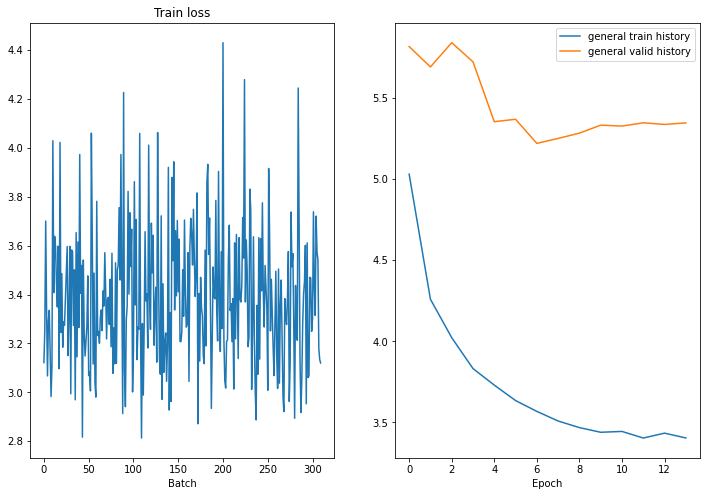

Epoch    15: reducing learning rate of group 0 to 2.4414e-06.
Epoch: 15 | Time: 2m 8s
	Train Loss: 3.382 | Train PPL:  29.424
	 Val. Loss: 5.351 |  Val. PPL: 210.828


In [38]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_bert, train_iterator, optimizer, criterion, CLIP, 
                       train_history, valid_history)
    valid_loss = evaluate(model_bert, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_bert.state_dict(), 'bert_model.pt')
    
    lr_scheduler.step(valid_loss)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Best Baseline with pretrained Bert emb model loss is 5.22


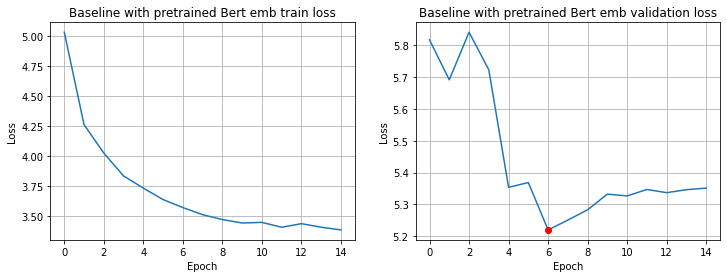

In [41]:
print_learning('Baseline with pretrained Bert emb', train_history, valid_history)

In [0]:
with open("bert_model.pt", "rb") as fp:
    best_bert_mod = model_bert
    state_dict = torch.load(fp, map_location=device)
    best_bert_mod.load_state_dict(state_dict)

In [75]:
original_text = []
generated_text = []
model_bert.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = model_bert(src, trg, 0) #turn off teacher forcing

        output = output.argmax(dim=-1).cpu().numpy()
        generated = get_text(list(output[1:, 0]), TRG.vocab)
        generated_text.append(' '.join(generated))
        original = get_text(list(trg[:,0].cpu().numpy()), TRG.vocab)
        original_text.append(' '.join(original))

59it [00:06,  8.99it/s]


In [77]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

19.4062698084439

In [63]:
batch = next(iter(test_iterator))
for idx in [2,3]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_bert, TRG.vocab)

Original: guests receive free on - site parking .
Generated: the property offers free parking .

Original: breakfast is served in the restaurant .
Generated: the can also a a drink at the bar .



#Results

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [0]:
res = pd.DataFrame({'model':['Baseline RNN', 'Attention model', 'Attention with regularization',
                       'RNN with with pretrained Bert emb'],
              'Num parameters':[14885415,16776516,16741671,131637490],
              'Train time per epoch':['1m 24s','2m 19s','2m 23s', '2m 8s'],
              'Val Loss':[4.807,4.414,4.274,5.22],
              'Blue Score':[13.580405981207116,  23.832946496516342,  29.680328123519413,  19.4062698084439]})
res['Num parameters'] = res['Num parameters'].map('{:,.0f}'.format)
res['Val Loss'] = res['Val Loss'].map('{:,.4f}'.format)

In [84]:
res.head().style.hide_index().background_gradient(cmap='RdYlGn')

model,Num parameters,Train time per epoch,Val Loss,Blue Score
Baseline RNN,"14,885,415",1m 24s,4.8070,13.580406
Attention model,"16,776,516",2m 19s,4.4140,23.832946
Attention with regularization,"16,741,671",2m 23s,4.2740,29.680328
RNN with with pretrained Bert emb,"131,637,490",2m 8s,5.2200,19.406270
